# Detailed Chemistry Modeling in PrOMMiS: Tutorial for Chemical Precipitation
*A step-by-step guide for integrating Reaktoro and PrOMMiS models to predict precipitation performance*


---

## 1. Introduction

Chemical precipitation is a core mechanism in water treatment, hydrometallurgy, brine treatment, and critical mineral recovery. It describes the process in which dissolved ions combine to form a solid mineral phase once their activities exceed the solubility limit of that mineral.

Learning objectives:

- Modeling precipitation of various minerals 
- Adding reagents to control pH and alkalinity
- Setting up and solving a PrOMMiS flowsheet model with integrated Reaktoro chemistry databases and calculations




---

## 2. What Is Chemical Precipitation?

Chemical precipitation occurs when the **ionic activity product (IAP)** of certain ions exceeds a mineral’s **solubility product (Ksp)**:

$$
\text{IAP} = \prod_i a_i^{\nu_i},\qquad
\text{If IAP} > K_\text{sp},\ \text{mineral formation occurs.}
$$

Typical mineral categories for critical mineral and brine systems include:

- **Carbonates** (e.g., calcite, dolomite, siderite)  
- **Sulfates** (e.g., gypsum, barite)  
- **Hydroxides** (e.g., Mg(OH)₂, Fe(OH)₃)  
- **Mixed solid solutions** (e.g., transition-metal hydroxides or carbonates)

Reaktoro allows defining any number of aqueous species and solids from selected thermodynamic databases (e.g., PHREEQC, SUPCRT, EQ3/6). PrOMMiS has the capability to develop a predictive model for the precipitation process. The integration of both capabilities inside the PrOMMiS hub would enhance the existing PrOMMiS model to consider detailed water chemistry.



---

## 3. Precipitation Processes Example Case
In this example, the goal is to precipitate calcium carbonate by adding lime ($\text{CaO}$) to raise the $\text{pH}$ above 7 and reduce the solubility of calcite, while adding soda ash will provide the carbonate (CO3) ions to facilitate calcite formation. Finally, the calcite ($\text{CaCO}_3$) precipitates in the sludge.

<img src="precipitation_pfd.png" alt="Chemical Precipitation PFD" width="80%">



The inlet water composition is given below (concentrations in $\text{mg/L}$ as the ion):

| Ion | Concentration ($\text{mg/L}$) |
| :--- | :--- |
| $\text{Na}^+$ | 10556 |
| $\text{K}^+$ | 380 |
| $\text{Ca}^{2+}$ | 400 |
| $\text{Mg}^{2+}$ | 1272 |
| $\text{Cl}^-$ | 18980 |
| $\text{SO}_4^{2-}$ | 2649 |
| $\text{HCO}_3^-$ | 140 |


Reagents **Sodium Carbonate** ($\text{Na}_2\text{CO}_3$) and **Calcium Oxide (Lime)** ($\text{CaO}$) as $\text{pH}$ adjusters, with doses of **1e-5 $\text{mol/L}$** and **1e-5 $\text{mol/L}$**, respectively.



# 4. Model Development for Precipitation Processes with Detailed Chemistry

This section details the development of the precipitation model. Our strategy involves a modular approach:

1.  **Develop the Process Flowsheet Model:** Define the unit operations using **PrOMMiS** components.
2.  **Develop the Detailed Chemistry Model:** Use **Reaktoro-PSE** to accurately calculate chemical equilibrium, speciation, and mineral precipitation (using the Pitzer database) for the high-salinity feed stream.
3.  **Integrate:** Transfer the calculated chemistry parameters from Reaktoro into the PrOMMiS property model to achieve high-fidelity process simulation.

---

### 4.1. Import Modules from the Library
Import the core packages from [Pyomo](https://pyomo.readthedocs.io/en/stable/index.html), [IDAES](https://idaes-pse.readthedocs.io/en/stable/), and [Reaktoro PSE](https://github.com/watertap-org/reaktoro-pse) that will be needed for the integration of detailed chemistry predictions. 

In [1]:
## Import core components
from pyomo.environ import (
    Var,
    Param,
    Constraint,
    Expression,
    Objective,
    ConcreteModel,
    Block,
    value,
    assert_optimal_termination,
    units as pyunits,
)
from pyomo.util.calc_var_value import calculate_variable_from_constraint

# Ideas core components
from idaes.core import FlowsheetBlock
from idaes.core.util.scaling import (set_scaling_factor, constraint_scaling_transform)
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.initialization import BlockTriangularizationInitializer
from idaes.core.solvers import get_solver
from customized_liquid_properties import AqueousParameter
from customized_solids_properties import PrecipitateParameters
from prommis.precipitate.precipitator import Precipitator
import pyomo.environ as pyo

# Import reaktoro-pse and reaktoro
from reaktoro_pse.reaktoro_block import ReaktoroBlock
import reaktoro
from reaktoro_pse.core.util_classes.cyipopt_solver import (get_cyipopt_watertap_solver)


### 4.2 PrOMMiS Precipitator Model
The PrOMMiS precipitator model consists of an equilibrium reactor with fixed partition coefficients. 
Requires 1 input and 2 outpus. 
The performance is determined by the "split" variable (m.fs.unit.cv_aquous.split), which determines the fixed recovery fraction of a given component; this factor can be a parameter or ideally a variable solved by a surrogate or a model equation.

Detailed description can be found here: https://prommis.readthedocs.io/en/latest/_autosummary/prommis.precipitate.precipitator.html#module-prommis.precipitate.precipitator

In [2]:
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)
m.fs.properties_aq = AqueousParameter()
m.fs.properties_solid = PrecipitateParameters()

m.fs.unit = Precipitator(
    property_package_aqueous=m.fs.properties_aq,
    property_package_precipitate=m.fs.properties_solid,
)

m.fs.unit.aqueous_inlet.flow_vol[0].fix(10000)  # mg/lt
m.fs.unit.aqueous_inlet.conc_mass_comp[0, "Na"].fix(10556)
m.fs.unit.aqueous_inlet.conc_mass_comp[0, "K"].fix(380)
m.fs.unit.aqueous_inlet.conc_mass_comp[0, "Ca"].fix(400)
m.fs.unit.aqueous_inlet.conc_mass_comp[0, "Mg"].fix(1272)
m.fs.unit.aqueous_inlet.conc_mass_comp[0, "Cl"].fix(18980)
m.fs.unit.aqueous_inlet.conc_mass_comp[0, "SO4"].fix(2649)
m.fs.unit.aqueous_inlet.conc_mass_comp[0, "HCO3"].fix(140)

m.fs.unit.precipitate_state_block[0].temperature.fix(298.15)

assert degrees_of_freedom(m.fs.unit) == 0
initializer = BlockTriangularizationInitializer(constraint_tolerance=2e-5)
initializer.initialize(m.fs.unit)
solver = get_solver()
results = solver.solve(m.fs.unit, tee=True)
assert_optimal_termination(results)

component keys that are not exported as part of the NL file.  Skipping.
Ipopt 3.13.2: nlp_scaling_method=gradient-based
tol=1e-06
max_iter=200


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the 

Note that this example assumes fixed performance (with default value for Ca precipitation).
Now lets print the result for "removal efficiency" 
Then, lets assume the process precipitates 42.3% of the Ca, and run again. 

In [3]:
print("\n--- Original Removal Efficiency ---")
print(f"Calcium Removal: {value(m.fs.properties_aq.split['Ca']):.2f} %")
print(f"Bicarbonate/Alkalinity Removal: {value(m.fs.properties_aq.split['HCO3']):.2f} %")
print("-" * 25)

# Fix performance
m.fs.properties_aq.split["Ca"] = 42.3 # assuming a fixed performance of the unit model
results = solver.solve(m.fs.unit, tee=False)
assert_optimal_termination(results)

print("\n--- Updated Removal Efficiency ---")
print(f"Calcium Removal: {value(m.fs.properties_aq.split['Ca']):.2f} %")
print(f"Bicarbonate/Alkalinity Removal: {value(m.fs.properties_aq.split['HCO3']):.2f} %")
print("-" * 25)


--- Original Removal Efficiency ---
Calcium Removal: 10.00 %
Bicarbonate/Alkalinity Removal: 0.00 %
-------------------------
component keys that are not exported as part of the NL file.  Skipping.

--- Updated Removal Efficiency ---
Calcium Removal: 42.30 %
Bicarbonate/Alkalinity Removal: 0.00 %
-------------------------


### 4.2. Integrating PrOMMiS Unit Model with Detailed Chemistry
An alternative to using fixed performance or surrogate models, is to integrate the model with a detailed chemistry package that predicts the precipitation based on the addition of agents and their concentration. 

In this example, the goal is to precipitate calcium carbonate by adding lime ($\text{CaO}$) to raise the $\text{pH}$ above 7 and reduce the solubility of calcite, while adding soda ash will provide the carbonate (CO3) ions to facilitate calcite formation. Finally, the calcite ($\text{CaCO}_3$) precipitates in the sludge.

As explained before, our goal is to precipitate calcium carbonate by adding lime ($\text{CaO}$) to raise the $\text{pH}$ above 7 and reduce the solubility of calcite, while adding soda ash will provide the carbonate (CO3) ions to facilitate calcite formation. Finally, the calcite ($\text{CaCO}_3$) precipitates in the sludge. The precipitation is given by the following balance:

$$ CaO \rightarrow Ca + H2O $$

$$ Na2CO3 \rightarrow 2Na + HCO3 $$

and for Calcite

$$ Ca + HCO3 \rightarrow CaCO3 (Calcite) $$

The first step is to create: a precipitation process block (as part of the precipiator PrOMMiS model). In this block, we will create all the parameters, variables, and constraints required to interface Reaktoro PSE package. 

In [4]:
# create new block as part of the precipitator PrOMMiS model
m.fs.unit.precipitation = Block()
#############################################################################
################## Aditional Variables and Paramters## ######################
ions = list(m.fs.properties_aq.component_list)  # read component list from precipitator property package
m.fs.unit.precipitation.feed_pH = Var(initialize=7.9)  # inlet pH - new variable
m.fs.unit.precipitation.feed_pressure = Var(initialize=1e5, units=pyunits.Pa)  # inlet pressure - new variable
m.fs.unit.precipitation.reagents_mol_flow = Var(["CaO", "Na2CO3"], initialize=1e-7, bounds=(1e-10, None),
                                            units=pyunits.mol / pyunits.s,)  #reagent mol flow - new variable
m.fs.unit.precipitation.reagent_dose = Var(["CaO", "Na2CO3"], initialize=1e-7, units=pyunits.mg / pyunits.kg)  # re-agent dose - new variable
m.fs.unit.precipitation.effluent_species_mass_flows = Var(ions, initialize=1e-5, units=pyunits.kg / pyunits.s)  # effluent flow - new variable
m.fs.unit.precipitation.precipitants = Var(["Calcite"], initialize=1e-32, units=pyunits.mol)  # precipitants - new variable
m.fs.unit.precipitation.effluent_pH = Var(initialize=7, bounds=(5, 12), units=pyunits.dimensionless)  # effluent pH - new variable
m.fs.unit.precipitation.effluent_alkalinity = Var(initialize=100, units=pyunits.mg / pyunits.L, bounds=(0.1, None))  # effluent alkalinity - new var

# Parameters
m.fs.unit.precipitation.reagents_mw = Param(["CaO", "Na2CO3"], units=pyunits.kg / pyunits.mol)  # re-agent molecular weight - new parameter
m.fs.unit.precipitation.precipitants_mw = Param(["Calcite"], initialize=100.09 / 1000, units=pyunits.kg / pyunits.mol)  # new parameter
m.fs.unit.precipitation.reagents_mw["CaO"] = 56.0774 / 1000
m.fs.unit.precipitation.reagents_mw["Na2CO3"] = 105.99 / 1000

#############################################################################
################## Aditional Constraints / Expressions ######################
m.fs.unit.precipitation.mass_in_ca = pyo.Expression(expr=
    m.fs.unit.cv_aqueous.properties_in[0].flow_mass_comp["Ca"]
    + m.fs.unit.precipitation.reagents_mol_flow["CaO"]
    * m.fs.unit.precipitation.reagents_mw["CaO"]
    * 0.7183)

m.fs.ca_removal = pyo.Constraint(expr= 
    m.fs.properties_aq.split["Ca"] == 100 * (
    1 - m.fs.unit.precipitation.effluent_species_mass_flows["Ca"] / m.fs.unit.precipitation.mass_in_ca))

m.fs.hco3_removal = pyo.Constraint(expr= m.fs.properties_aq.split["HCO3"] == 100 * (
    m.fs.unit.cv_aqueous.properties_in[0].flow_mass_comp["HCO3"]
        - m.fs.unit.precipitation.effluent_species_mass_flows["HCO3"]
    ) / m.fs.unit.cv_aqueous.properties_in[0].flow_mass_comp["HCO3"])

@m.fs.unit.precipitation.Constraint(ions)
def eq_effluent_species_mass_flows(fs, ion):
    if "Ca" == ion:
        return m.fs.unit.precipitation.effluent_species_mass_flows["Ca"] == (
            m.fs.unit.precipitation.reagents_mol_flow["CaO"] * m.fs.properties_aq.mw["Ca"]
            + m.fs.unit.cv_aqueous.properties_in[0].flow_mass_comp["Ca"]
            - m.fs.unit.precipitation.precipitants["Calcite"] * m.fs.properties_aq.mw["Ca"] / pyo.units.s
        )
    elif "Na" == ion:
        return m.fs.unit.precipitation.effluent_species_mass_flows["Na"] == (
            2
            * m.fs.unit.precipitation.reagents_mol_flow["Na2CO3"]
            * m.fs.properties_aq.mw["Na"]
            + m.fs.unit.cv_aqueous.properties_in[0].flow_mass_comp["Na"]
        )
    elif "HCO3" == ion:
        return m.fs.unit.precipitation.effluent_species_mass_flows["HCO3"] == (
            m.fs.unit.cv_aqueous.properties_in[0].flow_mass_comp["HCO3"]
            + m.fs.unit.precipitation.reagents_mol_flow["Na2CO3"]
            * m.fs.properties_aq.mw["HCO3"]
            - m.fs.unit.precipitation.precipitants["Calcite"] * m.fs.properties_aq.mw["HCO3"] / pyo.units.s
        )
    else:
        return (
            m.fs.unit.precipitation.effluent_species_mass_flows[ion]
            == m.fs.unit.cv_aqueous.properties_in[0].flow_mass_comp[ion]
        )

#############################################################################
################## Reaktoro-pse Interface (Inputs/Outputs ###################
m.fs.unit.precipitation.reaktoro_outputs = {
    ("speciesAmount", "Calcite",): m.fs.unit.precipitation.precipitants["Calcite"],
    ("alkalinityAsCaCO3", None): m.fs.unit.precipitation.effluent_alkalinity,
    ("pH", None): m.fs.unit.precipitation.effluent_pH,
    }
m.fs.unit.precipitation.eq_precipitation = ReaktoroBlock(
    aqueous_phase={
        "composition": m.fs.unit.cv_aqueous.properties_in[0].flow_mass_comp,
        "convert_to_rkt_species": True,
        "activity_model": reaktoro.ActivityModelPitzer(),
        "fixed_solvent_specie": "H2O",
    },
    system_state={
        "temperature": m.fs.unit.precipitate_state_block[0].temperature,
        "pressure": m.fs.unit.precipitation.feed_pressure,
        "pH": m.fs.unit.precipitation.feed_pH,
    },
    mineral_phase={"phase_components": ["Calcite"]},
    chemistry_modifier={
        "CaO": m.fs.unit.precipitation.reagents_mol_flow["CaO"],
        "Na2CO3": m.fs.unit.precipitation.reagents_mol_flow["Na2CO3"],
    },
    outputs=m.fs.unit.precipitation.reaktoro_outputs,
    database_file="pitzer.dat",
    build_speciation_block=True,
)

@m.fs.unit.precipitation.Constraint(["CaO", "Na2CO3"])
def eq_dose(fs, reagent):
    return m.fs.unit.precipitation.reagent_dose[reagent] == pyunits.convert(
        m.fs.unit.precipitation.reagents_mol_flow[reagent]
        * m.fs.unit.precipitation.reagents_mw[reagent]
        / m.fs.unit.cv_aqueous.properties_in[0].flow_mass_comp["H2O"],
        to_units=pyunits.mg / pyunits.kg,
    )

#############################################################################
################## Fix Inputs and Model Scaling #############################
m.fs.unit.precipitation.feed_pH.fix(7.9)  # fixing pH (value given in the problem statement)
m.fs.unit.precipitation.feed_pressure.fix(1e5)  # fixing pressure (value given in the problem statement)
m.fs.unit.precipitation.reagents_mol_flow["CaO"].fix(0.01)  # fixing reagent flow mol (value given in the problem statement)
m.fs.unit.precipitation.reagents_mol_flow["Na2CO3"].fix(0.01)  # fixing reagent flow mol (value given in the problem statement)
m.fs.properties_aq.split["Ca"].unfix()  # unfixing variable - the model performance is now linked to the reaktoro chemistry model
m.fs.properties_aq.split["HCO3"].unfix()  # unfixing variable - the model performance is now linked to the reaktoro chemistry model

# Scaling
set_scaling_factor(m.fs.unit.precipitation.feed_pH, 1)
set_scaling_factor(m.fs.unit.precipitate_state_block[0].temperature, 1 / 273)
set_scaling_factor(m.fs.unit.precipitation.feed_pressure, 1e-5)

# Initialization
for comp, pyoobj in m.fs.unit.precipitation.eq_effluent_species_mass_flows.items():
    calculate_variable_from_constraint(m.fs.unit.precipitation.effluent_species_mass_flows[comp], pyoobj)
    set_scaling_factor(m.fs.unit.precipitation.effluent_species_mass_flows[comp],
        1 / m.fs.unit.cv_aqueous.properties_in[0].flow_mass_comp[comp].value,)
    constraint_scaling_transform(pyoobj, 1 / m.fs.unit.cv_aqueous.properties_in[0].flow_mass_comp[comp].value)

for reagent in m.fs.unit.precipitation.reagents_mol_flow.keys():
    set_scaling_factor(m.fs.unit.precipitation.reagents_mol_flow[reagent], 1e4)
    set_scaling_factor(m.fs.unit.precipitation.reagent_dose[reagent], 1)
    constraint_scaling_transform(m.fs.unit.precipitation.eq_dose[reagent], 1)

for reagent in m.fs.unit.precipitation.precipitants.keys():
    set_scaling_factor(m.fs.unit.precipitation.precipitants[reagent], 1e4)
set_scaling_factor(m.fs.unit.precipitation.effluent_pH, 1)
m.fs.unit.precipitation.eq_precipitation.initialize()

# recompute effluent composition using updated amount of formed calcite
for comp, pyoobj in m.fs.unit.precipitation.eq_effluent_species_mass_flows.items():
    calculate_variable_from_constraint(m.fs.unit.precipitation.effluent_species_mass_flows[comp], pyoobj)

print('Model Degrees of Freedom = ' + str(degrees_of_freedom(m)))
solver = get_cyipopt_watertap_solver(max_iter=200, linear_solver="mumps", pivtol=1e-4)
result = solver.solve(m, tee=False)
assert_optimal_termination(result)  # check optimal condition

2025-12-23 17:36:47 [INFO] idaes.reaktoro_pse.core.reaktoro_inputs: Exact speciation is not provided! Fixing aqueous solvent and, excluding H
2025-12-23 17:36:47 [INFO] idaes.reaktoro_pse.core.reaktoro_inputs: Exact speciation is not provided! Fixing aqueous solvent and, excluding O
2025-12-23 17:36:48 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver inputs: ['[Cl]', '[C]', '[Na]', '[Mg]', '[S]', '[K]', '[Ca]', '[H2O]', '[H]', '[O]', '[H+]']
2025-12-23 17:36:48 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver constraints: ['charge', 'C_constraint', 'Na_constraint', 'Mg_constraint', 'S_constraint', 'K_constraint', 'Ca_constraint', 'H2O_constraint', 'H_dummy_constraint', 'O_dummy_constraint', 'pH']
2025-12-23 17:36:48 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver inputs: ['[H+]', '[H]', '[C]', '[O]', '[Na]', '[Mg]', '[S]', '[Cl]', '[K]', '[Ca]']
2025-12-23 17:36:48 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver constraints: ['charge', 'H_constrain

### 4.3. Results
The results show that the precipitation step removes ~42% of the calcium present in the influent after adding 201.8 mg/kg of lime and 381.5 [mg/kg] of soda ash. As can be observed, the pH started at 7 raising to 11.94 after adding the reagents.

In [5]:
# print results from Reaktoro object
print("--- Reaktoro Object Results ---")
for key, obj in m.fs.unit.precipitation.reaktoro_outputs.items():
    print(key, value(obj))

# Print Precipitator Model Results
print("\n-----------------------")
print("--- Results Summary ---")
print("--- Influent ---")
print(f"Treated Influent Flow - lt/hr: {value(m.fs.unit.aqueous_inlet.flow_vol[0]):.2f}")
print(f"Treated Influent pH: {value(m.fs.unit.precipitation.feed_pH):.2f}")
print(f"Treated Influent Temperature - K: {value(m.fs.unit.precipitate_state_block[0].temperature):.2f}")
print(f"Treated Influent Pressure - Pa: {value(m.fs.unit.precipitation.feed_pressure):.2f}")
print(f"Treated Influent Ca mass composition: {value(m.fs.unit.aqueous_inlet.conc_mass_comp[0, 'Ca']):.2f}")
print("\n--- Treated Effluent ---")
print(f"Treated Effluent Ca flow mass - kg/s: {value(m.fs.unit.cv_aqueous.properties_out[0].flow_mass_comp['Ca']):.2f}")
print(f"Treated Effluent H2O flow mass - kg/s: {value(m.fs.unit.cv_aqueous.properties_out[0].flow_mass_comp['H2O']):.2f}")
print(f"Treated Effluent pH: {value(m.fs.unit.precipitation.effluent_pH):.2f}")
print("-" * 25)
print("\n--- Precipitation Reagent Dosing ---")
print(f"Quicklime (CaO) Dose - mg/kg: {value(m.fs.unit.precipitation.reagent_dose['CaO']):.3f} [mg/kg]")
print(f"Soda Ash (Na2CO3) Dose - mg/kg: {value(m.fs.unit.precipitation.reagent_dose['Na2CO3']):.3f} [mg/kg]")
print("-" * 25)
print("\n--- Removal Efficiencies ---")
print(f"Calcium Removal: {value(m.fs.properties_aq.split['Ca']):.2f} %")
print(f"Bicarbonate/Alkalinity Removal: {value(m.fs.properties_aq.split['HCO3']):.2f} %")
print("-" * 25)

--- Reaktoro Object Results ---
('speciesAmount', 'Calcite') 0.01623646182274176
('alkalinityAsCaCO3', None) 0.2945122567723515
('pH', None) 11.160523533610903

-----------------------
--- Results Summary ---
--- Influent ---
Treated Influent Flow - lt/hr: 10000.00
Treated Influent pH: 7.90
Treated Influent Temperature - K: 298.15
Treated Influent Pressure - Pa: 100000.00
Treated Influent Ca mass composition: 400.00

--- Treated Effluent ---
Treated Effluent Ca flow mass - kg/s: 0.00
Treated Effluent H2O flow mass - kg/s: 2.78
Treated Effluent pH: 11.16
-------------------------

--- Precipitation Reagent Dosing ---
Quicklime (CaO) Dose - mg/kg: 201.879 [mg/kg]
Soda Ash (Na2CO3) Dose - mg/kg: 381.564 [mg/kg]
-------------------------

--- Removal Efficiencies ---
Calcium Removal: 43.12 %
Bicarbonate/Alkalinity Removal: 97.85 %
-------------------------


<img src="precipitation_pfd.png" alt="Chemical Precipitation PFD" width="80%">

### 4.3 Sensitivity Analysis
The sensitivity analysis captures the performance change when adjusting the molar flowrate of the lime and soda ash and its impact in the precipitation performance. Thus we can observe the efficiency of the process to precipitate calcium as a function of the lime and soda ash dose. In addition, we can observe the pH change as a function of lime and soda ash dose, which confirms our initial statement. The results confirm that raising the pH above 7 reduces the solubility of calcite, and adding soda ash facilitate calcite formation. 

In [6]:
import numpy as np 
import pyomo.environ as pyo
disturbance = np.linspace(0.01, 0.04, 5)  # process control disturbance - or change

# intermediate objects to store the results
pH = []
precipitants = []
alkal = []
ca_removal_l = []
hco3_removal_l = []
effluent_ph_l = []
soda_ash_dose_l = []
lime_dose_l = []

# solve a series of PrOMMiS optimization models to capture the disturbance effects on critical variables
for l in disturbance: 
    # update PrOMMiS model variable values
    m.fs.unit.precipitation.reagents_mol_flow["CaO"].fix(l)
    m.fs.unit.precipitation.reagents_mol_flow["Na2CO3"].fix(l)
    result = solver.solve(m, tee=False)  # solve model
    assert_optimal_termination(result)  # check model is optimal 
    # save results
    lime_dose_l.append(value(m.fs.unit.precipitation.reagent_dose["CaO"]))
    soda_ash_dose_l.append(value(m.fs.unit.precipitation.reagent_dose["Na2CO3"]))
    pH.append(m.fs.unit.precipitation.effluent_pH.value)
    precipitants.append(m.fs.unit.precipitation.precipitants["Calcite"].value)
    alkal.append(pyo.value(m.fs.unit.precipitation.effluent_alkalinity))
    ca_removal_l.append(value(m.fs.properties_aq.split['Ca']))
    hco3_removal_l.append(value(m.fs.properties_aq.split['HCO3']))

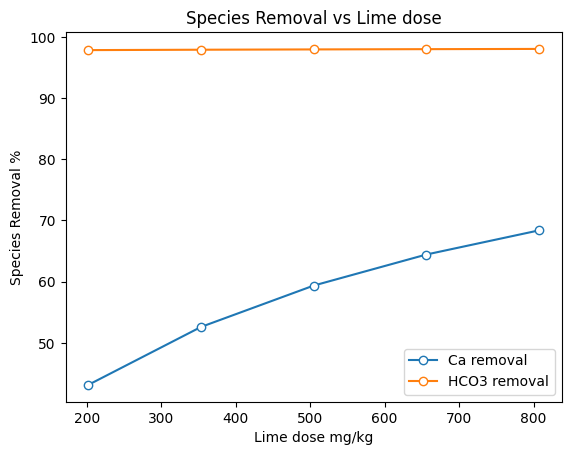

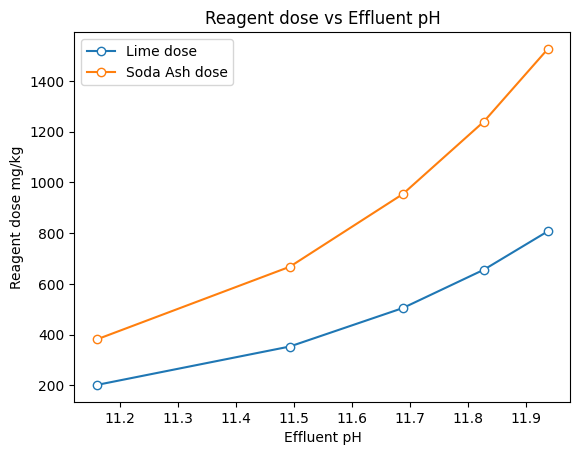

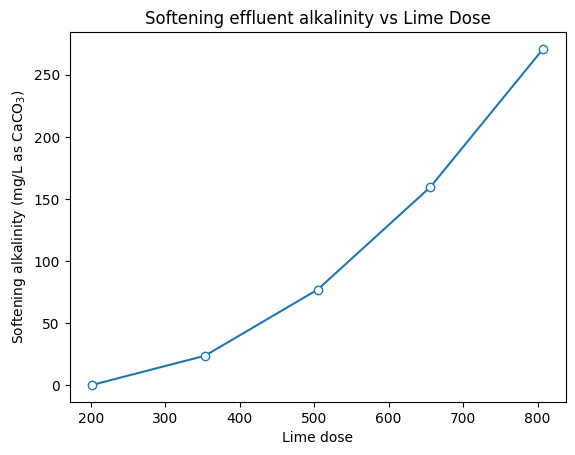

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(lime_dose_l,
        ca_removal_l,
        label="Ca removal",
        marker = "o",
        markerfacecolor="white",
       )
ax.plot(lime_dose_l,
        hco3_removal_l,
        label="HCO3 removal",
        marker = "o",
        markerfacecolor="white",
       )
        
ax.set_xlabel("Lime dose mg/kg")
ax.set_ylabel("Species Removal %")
ax.set_title(f"Species Removal vs Lime dose")
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(pH,
        lime_dose_l,
        label="Lime dose",
        marker = "o",
        markerfacecolor="white",
       )
ax.plot(pH,
        soda_ash_dose_l,
        label="Soda Ash dose",
        marker = "o",
        markerfacecolor="white",
       )
        
ax.set_xlabel("Effluent pH")
ax.set_ylabel("Reagent dose mg/kg")
ax.set_title(f"Reagent dose vs Effluent pH")
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(
    lime_dose_l,
    alkal,
    marker="o",
    markerfacecolor="white",
)
ax.set_xlabel("Lime dose")
ax.set_ylabel("Softening alkalinity (mg/L as CaCO$_3$)")
ax.set_title(f"Softening effluent alkalinity vs Lime Dose")
plt.show()